In [1]:
import tensorflow as tf
import numpy as np
import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import DenseNet121, ResNet50

In [2]:
# -----------------------------
# PARAMETERS
# -----------------------------
data_dir = "./dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 15
N_SPLITS = 5   # 5-fold CV
MODEL_LIST = ["DenseNet121", "ResNet50"]   # Run both

In [3]:
# -----------------------------
# LOAD FILES & LABELS
# -----------------------------
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_index = {c: i for i, c in enumerate(classes)}

all_image_paths, all_labels = [], []
for cls in classes:
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([class_to_index[cls]] * len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Classes:", classes)
print("Dataset size:", len(all_image_paths))

Classes: ['normal', 'osteoporosis']
Dataset size: 372


In [4]:
# -----------------------------
# IMAGE PREPROCESSING FUNCTIONS
# -----------------------------
def normalize_image_rgb(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)  # grayscale
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.tile(img, [1, 1, 3])  # grayscale → RGB
    return img, label

def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.15)
    img = tf.image.random_contrast(img, 0.85, 1.15)
    img = tf.image.random_jpeg_quality(img, 70, 100)
    img = tf.image.random_saturation(img, 0.9, 1.1)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k=k)
    return img, label

In [5]:
# -----------------------------
# MODEL BUILDER
# -----------------------------
def build_model(input_shape=(224,224,3), base="DenseNet121"):
    if base == "DenseNet121":
        base_model = DenseNet121(include_top=False, weights="imagenet", input_shape=input_shape)
    elif base == "ResNet50":
        base_model = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    else:
        raise ValueError("Invalid base model")

    # Freeze most layers, fine-tune last 30
    for layer in base_model.layers[:-30]:
        layer.trainable = False
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [6]:
# -----------------------------
# CALLBACKS
# -----------------------------
def get_callbacks():
    early_stop = callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
    return [early_stop, reduce_lr]

In [7]:
# -----------------------------
# 📌 Evaluation Helper
# -----------------------------
def evaluate_and_report(model, dataset, split_name="Validation"):
    y_true, y_pred = [], []
    
    for imgs, lbls in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(lbls.numpy().astype("int32"))
        y_pred.extend((preds > 0.5).astype("int32").flatten())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = np.mean(y_true == y_pred)
    print(f"\n{split_name} Accuracy: {acc*100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes,
                yticklabels=classes)
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



================= DenseNet121 =================

========== DenseNet121 Fold 1/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 291s 7s/step - accuracy: 0.6061 - loss: 0.7757 - val_accuracy: 0.5067 - val_loss: 0.9118 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.6465 - loss: 0.6911 - val_accuracy: 0.5067 - val_loss: 0.7333 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6633 - loss: 0.6617 - val_accuracy: 0.6000 - val_loss: 0.6342 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.6835 - loss: 0.6509 - val_accuracy: 0.7200 - val_loss: 0.5783 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.7475 - loss: 0.5538 - val_accuracy: 0.7600 - val_loss: 0.5601 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.7609 - loss: 0.5789 - val_accuracy: 0.7333 - val_loss: 0.5488 - learni

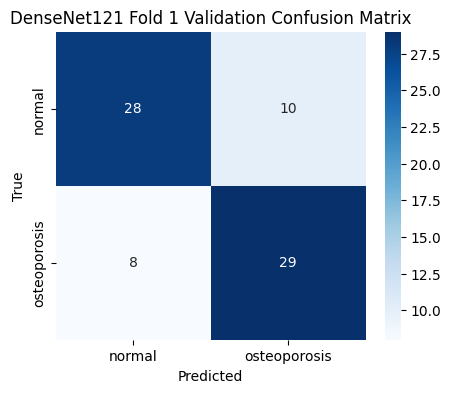


========== DenseNet121 Fold 2/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 398s 8s/step - accuracy: 0.5152 - loss: 0.8607 - val_accuracy: 0.7333 - val_loss: 0.6146 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.6364 - loss: 0.6307 - val_accuracy: 0.7067 - val_loss: 0.5798 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 110s 5s/step - accuracy: 0.6869 - loss: 0.6346 - val_accuracy: 0.7067 - val_loss: 0.5541 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.7138 - loss: 0.5813 - val_accuracy: 0.7333 - val_loss: 0.5354 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.7475 - loss: 0.5537 - val_accuracy: 0.7467 - val_loss: 0.5353 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7239 - loss: 0.5518 - val_accuracy: 0.7600 - val_loss: 0.5307 - learning_rate: 1.0000e-04
Epoch 7/15
19/19 ━━━━━━━━━━━━

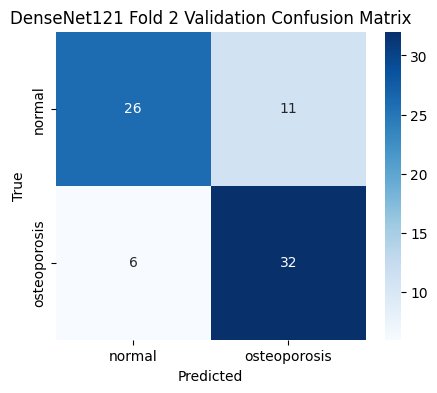


========== DenseNet121 Fold 3/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 401s 9s/step - accuracy: 0.5369 - loss: 0.8037 - val_accuracy: 0.6757 - val_loss: 0.6420 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.6242 - loss: 0.6301 - val_accuracy: 0.7027 - val_loss: 0.6076 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.6275 - loss: 0.6500 - val_accuracy: 0.7568 - val_loss: 0.5568 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.7148 - loss: 0.5877 - val_accuracy: 0.7703 - val_loss: 0.5404 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.7215 - loss: 0.6179 - val_accuracy: 0.7703 - val_loss: 0.5233 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 115s 6s/step - accuracy: 0.7081 - loss: 0.5903 - val_accuracy: 0.7838 - val_loss: 0.5208 - learning_rate: 1.0000e-04
Epoch 7/15
19/19 ━━━━━━━━━━━

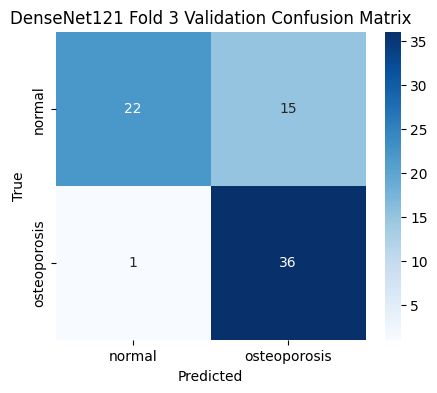


========== DenseNet121 Fold 4/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 231s 7s/step - accuracy: 0.5470 - loss: 0.8453 - val_accuracy: 0.7027 - val_loss: 0.6072 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.6443 - loss: 0.7214 - val_accuracy: 0.7568 - val_loss: 0.5592 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - accuracy: 0.7383 - loss: 0.5444 - val_accuracy: 0.7703 - val_loss: 0.5427 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.6846 - loss: 0.6621 - val_accuracy: 0.7838 - val_loss: 0.5251 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.6711 - loss: 0.5935 - val_accuracy: 0.7973 - val_loss: 0.5147 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.7215 - loss: 0.5854 - val_accuracy: 0.7838 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 7/15
19/19 ━━━━━━━━━━

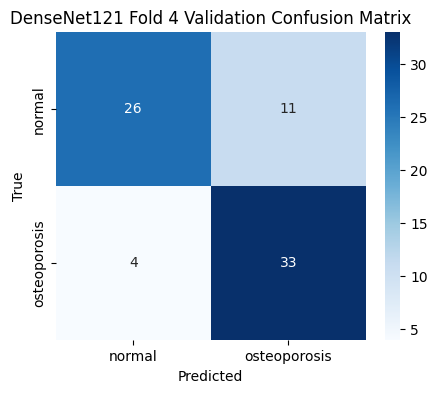


========== DenseNet121 Fold 5/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 372s 11s/step - accuracy: 0.5369 - loss: 0.8001 - val_accuracy: 0.4730 - val_loss: 0.7054 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.6208 - loss: 0.7131 - val_accuracy: 0.6622 - val_loss: 0.6469 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.7215 - loss: 0.5933 - val_accuracy: 0.7162 - val_loss: 0.6164 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.7215 - loss: 0.5954 - val_accuracy: 0.7162 - val_loss: 0.5941 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7181 - loss: 0.6147 - val_accuracy: 0.7297 - val_loss: 0.5774 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.7383 - loss: 0.5795 - val_accuracy: 0.7297 - val_loss: 0.5574 - learning_rate: 1.0000e-04
Epoch 7/15
19/19 ━━━━━━━━━━━━━

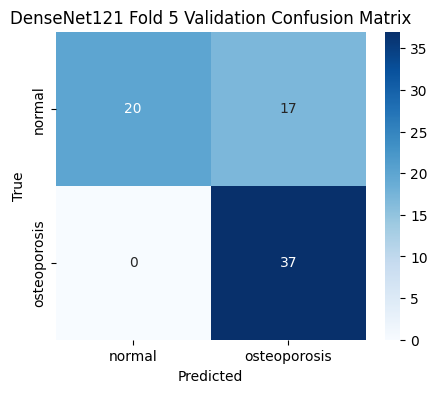



================= ResNet50 =================

========== ResNet50 Fold 1/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 407s 8s/step - accuracy: 0.5960 - loss: 1.0276 - val_accuracy: 0.5067 - val_loss: 0.6981 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.6229 - loss: 0.8210 - val_accuracy: 0.5067 - val_loss: 0.6951 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.6970 - loss: 0.7446 - val_accuracy: 0.6667 - val_loss: 0.6824 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 120s 6s/step - accuracy: 0.6734 - loss: 0.7208 - val_accuracy: 0.5067 - val_loss: 0.7080 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - accuracy: 0.7037 - loss: 0.7381 - val_accuracy: 0.5067 - val_loss: 0.7070 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 126s 6s/step - accuracy: 0.6734 - loss: 0.7702 - val_accuracy: 0.5067 - val_loss: 0.7161 - learning_

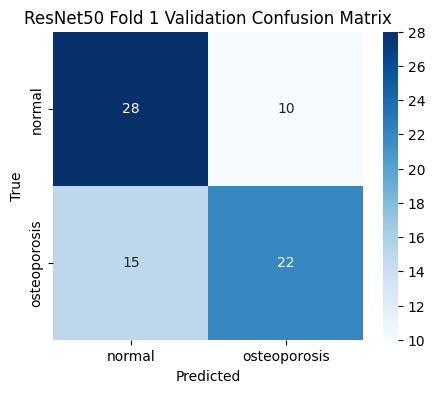


========== ResNet50 Fold 2/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 336s 9s/step - accuracy: 0.5892 - loss: 0.9629 - val_accuracy: 0.5067 - val_loss: 0.7403 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.6667 - loss: 0.7971 - val_accuracy: 0.5067 - val_loss: 0.7197 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - accuracy: 0.6835 - loss: 0.7431 - val_accuracy: 0.3200 - val_loss: 0.7092 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - accuracy: 0.6970 - loss: 0.7985 - val_accuracy: 0.3733 - val_loss: 0.6999 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 128s 6s/step - accuracy: 0.6700 - loss: 0.7372 - val_accuracy: 0.7067 - val_loss: 0.6268 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.6700 - loss: 0.8320 - val_accuracy: 0.7200 - val_loss: 0.6119 - learning_rate: 1.0000e-04
Epoch 7/15
19/19 ━━━━━━━━━━━━

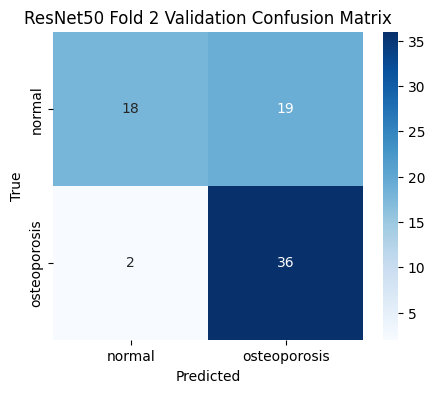


========== ResNet50 Fold 3/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 302s 9s/step - accuracy: 0.5973 - loss: 0.9456 - val_accuracy: 0.5000 - val_loss: 0.9193 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 118s 6s/step - accuracy: 0.6544 - loss: 0.9373 - val_accuracy: 0.5000 - val_loss: 0.8873 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.6477 - loss: 0.9175 - val_accuracy: 0.5000 - val_loss: 0.8205 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step - accuracy: 0.6342 - loss: 0.9178 - val_accuracy: 0.5000 - val_loss: 0.8075 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - accuracy: 0.6208 - loss: 0.8501 - val_accuracy: 0.5000 - val_loss: 0.7694 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.6611 - loss: 0.7945 - val_accuracy: 0.5000 - val_loss: 0.7810 - learning_rate: 1.0000e-04
ResNet50 Fold 3 Validation Ac

C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

      normal       0.50      1.00      0.67        37
osteoporosis       0.00      0.00      0.00        37

    accuracy                           0.50        74
   macro avg       0.25      0.50      0.33        74
weighted avg       0.25      0.50      0.33        74



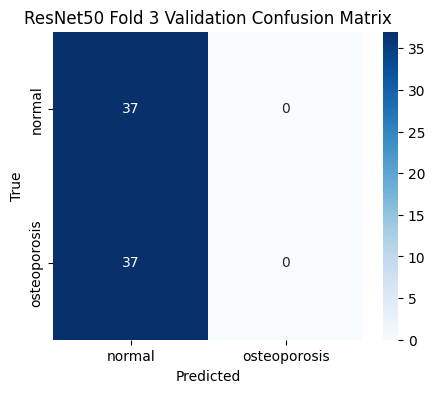


========== ResNet50 Fold 4/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 342s 14s/step - accuracy: 0.6040 - loss: 0.9823 - val_accuracy: 0.5000 - val_loss: 0.7730 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.6107 - loss: 0.8858 - val_accuracy: 0.5000 - val_loss: 0.7543 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step - accuracy: 0.6913 - loss: 0.7315 - val_accuracy: 0.5000 - val_loss: 0.7214 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 169s 8s/step - accuracy: 0.6477 - loss: 0.7960 - val_accuracy: 0.5405 - val_loss: 0.6658 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 170s 8s/step - accuracy: 0.6544 - loss: 0.8574 - val_accuracy: 0.6757 - val_loss: 0.6303 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.7181 - loss: 0.7387 - val_accuracy: 0.6757 - val_loss: 0.6234 - learning_rate: 1.0000e-04
Epoch 7/15
19/19 ━━━━━━━━━━━

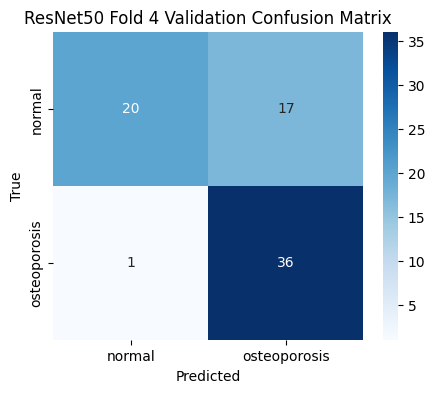


========== ResNet50 Fold 5/5 ==========
Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.5906 - loss: 1.0631 - val_accuracy: 0.5000 - val_loss: 0.9079 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6812 - loss: 0.8916 - val_accuracy: 0.5000 - val_loss: 0.8655 - learning_rate: 1.0000e-04
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6711 - loss: 0.8448 - val_accuracy: 0.5000 - val_loss: 0.8426 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6544 - loss: 0.8498 - val_accuracy: 0.5000 - val_loss: 0.7772 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6946 - loss: 0.7617 - val_accuracy: 0.5000 - val_loss: 0.7230 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6711 - loss: 0.7659 - val_accuracy: 0.5000 - val_loss: 0.6911 - learning_rate: 1.0000e-04
ResNet50 Fold 5 Validation Accurac

C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        37
osteoporosis       0.50      1.00      0.67        37

    accuracy                           0.50        74
   macro avg       0.25      0.50      0.33        74
weighted avg       0.25      0.50      0.33        74



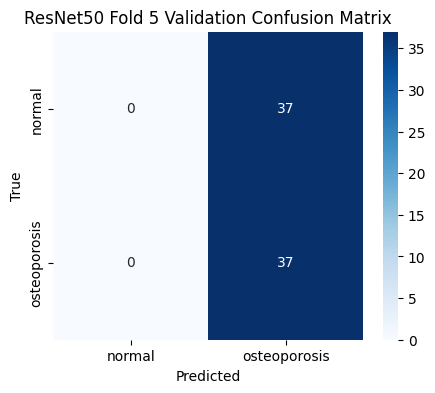

In [8]:
# -----------------------------
# RUN BOTH MODELS WITH K-FOLD
# -----------------------------
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

for MODEL_NAME in MODEL_LIST:
    print(f"\n\n================= {MODEL_NAME} =================")

    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    val_accuracies = []
    models_list = []
    last_y_test, last_test_ds = None, None

    for fold, (train_idx, test_idx) in enumerate(kf.split(all_image_paths, all_labels)):
        print(f"\n========== {MODEL_NAME} Fold {fold+1}/{N_SPLITS} ==========")

        X_train, X_test = all_image_paths[train_idx], all_image_paths[test_idx]
        y_train, y_test = all_labels[train_idx], all_labels[test_idx]

        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_ds = train_ds.map(normalize_image_rgb, num_parallel_calls=AUTOTUNE)
        train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE)
        train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

        test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_ds = test_ds.map(normalize_image_rgb, num_parallel_calls=AUTOTUNE)
        test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

        model = build_model(base=MODEL_NAME)

        history = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=EPOCHS,
            callbacks=get_callbacks(),
            verbose=1
        )

        val_loss, val_acc = model.evaluate(test_ds, verbose=0)
        print(f"{MODEL_NAME} Fold {fold+1} Validation Accuracy: {val_acc:.4f}")
        val_accuracies.append(val_acc)
        models_list.append(model)

        evaluate_and_report(model, test_ds, split_name=f"{MODEL_NAME} Fold {fold+1} Validation")

        last_y_test, last_test_ds = y_test, test_ds

In [9]:
# -----------------------------
# REPORT CV RESULTS
# -----------------------------
print(f"\n========== {MODEL_NAME} CROSS-VALIDATION RESULTS ==========")
print(f"Validation Accuracy Mean: {np.mean(val_accuracies)*100:.2f}%")
print(f"Validation Accuracy Std : {np.std(val_accuracies)*100:.2f}%")



========== ResNet50 CROSS-VALIDATION RESULTS ==========
Validation Accuracy Mean: 62.87%
Validation Accuracy Std : 10.89%


In [10]:
# -----------------------------
    # OPTIONAL ENSEMBLE
    # -----------------------------
def ensemble_predict(models, dataset):
    preds = [m.predict(dataset, verbose=0) for m in models]
    preds = np.mean(preds, axis=0)  # average probabilities
    preds = (preds > 0.5).astype(int)
    return preds

if last_test_ds is not None:
    ensemble_preds = ensemble_predict(models_list, last_test_ds)
    ensemble_acc = np.mean(ensemble_preds.flatten() == last_y_test)
    print(f"\n{MODEL_NAME} Ensemble Test Accuracy: {ensemble_acc*100:.2f}%")

    print("\nEnsemble Classification Report:")
    print(classification_report(last_y_test, ensemble_preds.flatten(), target_names=classes))

    cm = confusion_matrix(last_y_test, ensemble_preds.flatten())
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=classes,
                yticklabels=classes)
    plt.title(f"{MODEL_NAME} Ensemble Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

SystemError: D:\a\1\s\Objects\listobject.c:338: bad argument to internal function